# Single Fire Avoidance with Constant Wind

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import multivariate_normal
from scipy.integrate import solve_bvp

## Defining the Obstacle and it's Partial Derivatives 
### Constant Wind Vector

In math --  

Parameters:
* $(x_0, y_0)$: Initial Location of the Fire.
* $\mathbf{w} = (w_1, w_2)$: Wind Vector
* $\sigma_0$: Initial Standard Deviation
* $k$: Growth Rate in Direction of the Wind
* $c$: Growth Rate Perpindicular to the Wind

We compute the unit vectors in the direction of the wind and perpendicular to the wind:  

$$u_x = \frac{w_1}{||\mathbf{w}||} \qquad u_y = \frac{w_2}{||\mathbf{w}||} \qquad u_x^\perp = -u_y \qquad u_y^\perp = u_x $$

Then a given time $t$, the mean and variance of the fire are described as follows:  
$$\mu = \begin{bmatrix}x_0 + w_1t & y_0 + w_2t\end{bmatrix}$$  
$$ \Sigma = \begin{bmatrix} u_x^2\sigma_\parallel + u_y^2\sigma_\perp & u_xu_y(\sigma_\parallel - \sigma_\perp) \\u_xu_y(\sigma_\parallel - \sigma_\perp) & u_y^2\sigma_\parallel + u_x^2\sigma_\perp \end{bmatrix} $$

where we define $$ \sigma_\parallel = \sigma_0^2 + kt \qquad \sigma_\perp = \sigma_0^2 + ct $$

Finally, we have our fire defined as $$ F(t, \mathbf{z}) \sim \mathscr{N}\big(\mathbf{z} | \mu(t), \Sigma(t)\big) $$

Thankfully, $\Sigma(t)$ has no dependence on $x$ or $y$. Our costate equations will ultimately depend on $F_x$, and $F_y$, so we compute them below.

$$\nabla F = -F\Sigma^{-1}(\mathbf{z} - \mu)$$

In [17]:
fire_cost = 50_000 # Cost of fire

def fire(t, x, y, x0, y0, w1, w2, u_x, u_y, sigma2_0, k, c):
    """
    Fire dynamics model.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    w1 (float): Wind speed in x-direction
    w2 (float): Wind speed in y-direction
    u_x (float): Wind direction in x (unit vector)
    u_y (float): Wind direction in y (unit vector)
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    float: Fire intensity at time t
    """
    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements for each t
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute determinant and inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")

    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    # Compute exponent
    exponent = -0.5 * (inv_11 * dx**2 + 2 * inv_12 * dx * dy + inv_22 * dy**2)
    normalization = 1.0 / (2 * np.pi * np.sqrt(det))
    return fire_cost * normalization * np.exp(exponent)

def grad_fire(t, x, y, x0, y0, w1, w2, u_x, u_y, sigma2_0, k, c):
    """
    Gradient of fire intensity.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    w1 (float): Wind speed in x-direction
    w2 (float): Wind speed in y-direction
    u_x (float): Wind direction in x (unit vector)
    u_y (float): Wind direction in y (unit vector)
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    np.ndarray: Gradient of fire intensity
    """
    f = fire(t, x, y, x0, y0, w1, w2, u_x, u_y, sigma2_0, k, c)
    
    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")
    
    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    grad_x = -f * (inv_11 * dx + inv_12 * dy)
    grad_y = -f * (inv_12 * dx + inv_22 * dy)
    
    return grad_x, grad_y

## Initial Conditions

In [18]:
# Parameters
target = np.array([15., 5.])
x0, y0 = 0., 0.
w1, w2 = 0.75, 0.5
sigma_0 = 0.1
k = 2
c = 1
control_penalty = 10
time_penalty = 10

u_norm = np.sqrt(w1**2 + w2**2)
u_x = w1 / u_norm
u_y = w2 / u_norm

s0 = np.array([-5, -5, 0, 0])

def fire_ode(t, z, p):
    x, y, vx, vy, p1, p2, p3, p4 = z
    tf = np.clip(p[0], 0, None)
    f_x, f_y = grad_fire(tf * t, x, y, x0, y0, w1, w2, u_x, u_y, sigma_0**2, k, c)
    return p[0] * np.array([
        vx,
        vy,
        0.5 * p3 / control_penalty,
        0.5 * p4 / control_penalty,
        f_x,
        f_y,
        -p1,
        -p2
    ])

def bc(ya, yb, p):
    x, y, vx, vy, p1, p2, p3, p4 = yb
    u1, u2 = 0.5 * p3 / control_penalty, 0.5 * p4 / control_penalty
    tf = np.clip(p[0], 0, None)
    H = p1*vx + p2*vy + p3*u1 + p4*u2 - (time_penalty * p[0] + fire(tf, x, y, x0, y0, w1, w2, u_x, u_y, sigma_0**2, k, c) + control_penalty * (u1**2 + u2**2) / 2)
    return np.array([
        ya[0] - s0[0],
        ya[1] - s0[1],
        ya[2] - s0[2],
        ya[3] - s0[3],
        yb[0] - target[0],
        yb[1] - target[1],
        yb[2],
        yb[3],
        H
    ])

# Initial mesh and guess
t_steps = 100
t = np.linspace(0, 1, t_steps)
z0 = np.zeros((8, t_steps))
z0[0, :] = np.linspace(s0[0], target[0], t_steps)
z0[1, :] = np.linspace(s0[1], target[1], t_steps)
p0 = np.array([1.0])
v_guess = (target - s0[:2]) / p0[0]
z0[2, :] = v_guess[0]
z0[3, :] = v_guess[1]

# Solve BVP
sol = solve_bvp(fire_ode, bc, t, z0, p0, tol=1e-3, max_nodes=50000)

if not sol.success:
    print("BVP solver failed:", sol.message)

In [19]:
tf = sol.p[0]
print("Final Time:", round(tf, 3))

Final Time: 7.456


7.455924061685617
t_eval.shape = (892,)
x_traj.shape = (892,)
y_traj.shape = (892,)


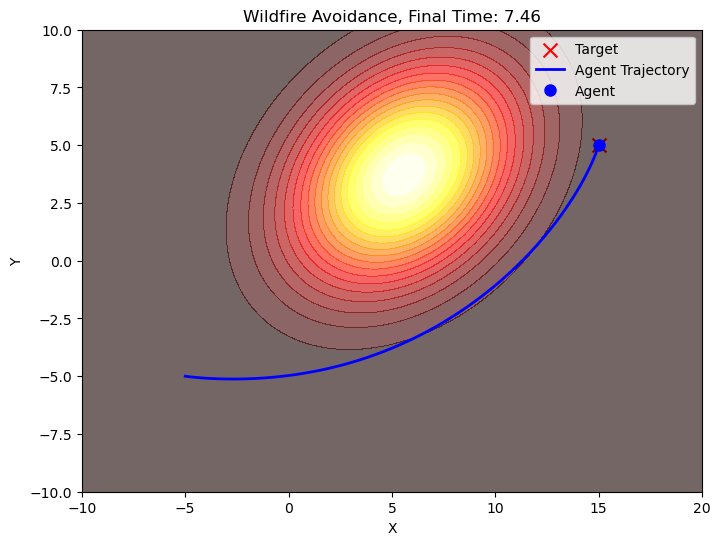

In [20]:
# Define the grid for plotting
x, y = np.linspace(-10, 20, 100), np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

tf = sol.p[0]
print(tf)
t_eval = np.linspace(0, tf, len(sol.y[0]))
x_traj = sol.y[0]
y_traj = sol.y[1]

print(f"t_eval.shape = {t_eval.shape}")
print(f"x_traj.shape = {x_traj.shape}")
print(f"y_traj.shape = {y_traj.shape}")

# Set up figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Wildfire Avoidance, Final Time: {tf:.2f}')

# Plot static target
ax.scatter(target[0], target[1], marker='x', color='red', s=100, label='Target')

# Initialize dynamic elements
contour = None
traj_line, = ax.plot([], [], 'b-', lw=2, label='Agent Trajectory')
current_pos, = ax.plot([], [], 'bo', markersize=8, label='Agent')
ax.legend()

def update(t_anim):
    global contour
    # Remove old contour if it exists
    if contour:
        for coll in contour.collections:
            coll.remove()
    
    # Fire parameters at time t_anim
    mean_x = x0 + w1 * t_anim
    mean_y = y0 + w2 * t_anim
    sigma_parallel = sigma_0**2 + k * t_anim
    sigma_perp = sigma_0**2 + c * t_anim

    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp

    Sigma = np.array([[cov_11, cov_12], [cov_12, cov_22]])

    # Stabilize Sigma if necessary
    min_eig = np.linalg.eigvalsh(Sigma).min()
    if min_eig <= 0:
        Sigma += 1e-6 * np.eye(2)

    # Manual PDF
    det = cov_11 * cov_22 - cov_12**2
    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det
    dx = X - mean_x
    dy = Y - mean_y
    exponent = -0.5 * (inv_11 * dx**2 + 2 * inv_12 * dx * dy + inv_22 * dy**2)
    Z = np.exp(exponent) / (2 * np.pi * np.sqrt(det))

    # Plot fire density
    contour = ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.6)

    # Update trajectory
    mask = t_eval <= t_anim
    traj_line.set_data(x_traj[mask], y_traj[mask])
    if mask.any():
        current_pos.set_data([x_traj[mask][-1]], [y_traj[mask][-1]])
    
    # Don't return anything for blitting, just rely on full redraw
    return []

# Animate without blitting (works reliably with contourf)
t_values = np.linspace(0, tf, 50)
ani = animation.FuncAnimation(
    fig, update, frames=t_values,
    blit=False, interval=50, repeat=True
)

ani.save('fire_spread_with_trajectory.mp4', writer='ffmpeg', fps=15)
plt.show()


## Varying Wind Vector